In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
pip install Kaggle

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install Ipython

Note: you may need to restart the kernel to use updated packages.


# 1. DATA PREPARATION
## Reading the Data
## Unifying the Data

* Check whether the values in the columns are correctly input.


In [12]:
%time

df=pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")



CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 13.6 µs


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [ ]:
df.columns.str.replace(' ','_').str.lower()

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [ ]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [ ]:
df.columns=df.columns.str.replace(' ','_').str.lower()

categorical_columns=list(df.dtypes[df.dtypes=='object'].index)

categorical_columns

for c in categorical_columns:
    df[c]= df[c].str.lower().str.replace(' ','_')

In [ ]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.5,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


In [ ]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [ ]:
#Convert object to int/float and viceversa to the data that is incongruent


df.totalcharges=pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges=df.totalcharges.fillna(0)

In [ ]:
df.churn=(df.churn=='yes').astype(int)

df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

# 3.3 Setting Up the Validation Framework

* Perform the train/validation/test split with Scikit-Learn

In [ ]:
from sklearn.model_selection import train_test_split

df_full_train, df_test= train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
df_train, df_val= train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)


In [ ]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [ ]:
y_train=df_train.churn.values
y_val=df_val.churn.values
y_test=df_test.churn.values

y_full_train= df_full_train.churn.values

In [ ]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

# 3.4 EDA
* Check missng values
* Look at the target variable(churn)
* Look at numerical and categorical variables

In [ ]:
# we use the full train dataset for EDA
df_full_train=df_full_train.reset_index(drop=True)

In [ ]:
df_full_train.isnull().sum()# there are no missing values. One less thing to worry about

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [ ]:
# looking at the target variable

df_full_train.churn.value_counts(normalize=True)

# we see that app 26% of users are churning users. That is what is called the churn rate(global)

0    0.730032
1    0.269968
Name: churn, dtype: float64

In [ ]:
global_churn_rate=df_full_train.churn.mean()
round(global_churn_rate, 2)

0.27

In [ ]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [ ]:
df_full_train.dtypes

numerical=['tenure','monthlycharges','totalcharges']

categorical= ['gender', 'seniorcitizen', 'partner', 'dependents','phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [ ]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# 3.5 Feature Importance : Churn Rate and Risk Ratio
Feature Importnace analysis is part of EDA- it involves determining which features affect the target variable more.

* Churn Rate
* Risk Ratio
* Mutual Information- later



### Churn Rate

In [ ]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [ ]:
count=df_full_train.churn.value_counts()
count

0    4113
1    1521
Name: churn, dtype: int64

In [ ]:
churn_female=df_full_train[df_full_train['gender']=='female'].churn.mean()
churn_female

0.27682403433476394

In [ ]:
churn_male=df_full_train[df_full_train.gender=='male'].churn.mean()
churn_male

0.2632135306553911

In [ ]:
global_churn=df_full_train.churn.mean()
global_churn

0.26996805111821087

In [ ]:
churn_partner=df_full_train[df_full_train.partner=='yes'].churn.mean()
churn_partner

0.20503330866025166

In [ ]:
churn_partner_non=df_full_train[df_full_train.partner=='no'].churn.mean()
churn_partner_non

0.3298090040927694

### Risk Ratio

In [ ]:
churn_partner_non/global_churn

1.2216593879412643

In [ ]:
churn_partner/global_churn

0.7594724924338315

In [ ]:
#from Ipython.display import display

In [ ]:
df.paymentmethod.value_counts()

electronic_check             2365
mailed_check                 1612
bank_transfer_(automatic)    1544
credit_card_(automatic)      1522
Name: paymentmethod, dtype: int64

In [ ]:
# we can implement a SQL query using pandas so that we determine the churn diff and risk ratio for all other features easily
for c in categorical:
    print(c)
    df_group=df_full_train.groupby(c).churn.agg(['mean','count'])

    df_group['diff']=df_group['mean']- global_churn
    df_group['risk']=df_group['mean']/ global_churn

df_group
    
    
    

gender
seniorcitizen
partner
dependents
phoneservice
multiplelines
internetservice
onlinesecurity
onlinebackup
deviceprotection
techsupport
streamingtv
streamingmovies
contract
paperlessbilling
paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


## 3.6 Feature Importance: Mutual Information
Mutual information- concept from the information theory, it tells us how much we can learn about one variable if we know the value of another

In [ ]:
from sklearn.metrics import mutual_info_score

In [ ]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

0.0983203874041556

In [ ]:
mutual_info_score(df_full_train.gender, df_full_train.churn)

0.0001174846211139946

In [ ]:
mutual_info_score(df_full_train.churn, df_full_train.partner)

0.009967689095399745

In [ ]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

In [ ]:
# Now lets check the mutual information of all the features against churn to idenfity the most important

mi=df_full_train[categorical].apply(mutual_info_churn_score)

# lets sort it
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

We can see that relatively , the really important variables are contract, onlinesecuritty, techsupprt, internetservice, onlinebackcup etc.

The least important are gender, phone service, multiplelines etc.

## 3.7 Feature Importance: Correlation

How about numerical columns
* Correlation Coefficient

In [ ]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [ ]:
df_full_train[df_full_train.tenure<=2].churn.mean()

0.5953420669577875

In [ ]:
df_full_train[(df_full_train.tenure >2) & (df_full_train.tenure<=12)].churn.mean()

0.3994413407821229

In [ ]:
df_full_train[df_full_train.tenure>12].churn.mean()

0.17634908339788277

In [ ]:
df_full_train[df_full_train.monthlycharges <=20].churn.mean()

0.08795411089866156

In [ ]:
df_full_train[(df_full_train.monthlycharges >20) & (df_full_train.monthlycharges<=50)].churn.mean()

0.18340943683409436

In [ ]:
df_full_train[df_full_train.monthlycharges >50].churn.mean()

0.32499341585462205

## 3.8 One-Hot Encoding

* We'll use Scikit-Learn to encode categorical features

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
train_dicts=df_train[categorical + numerical].to_dict(orient="records")
train_dicts[-1:]

[{'gender': 'female',
  'seniorcitizen': 1,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'fiber_optic',
  'onlinesecurity': 'no',
  'onlinebackup': 'no',
  'deviceprotection': 'no',
  'techsupport': 'no',
  'streamingtv': 'yes',
  'streamingmovies': 'no',
  'contract': 'month-to-month',
  'paperlessbilling': 'yes',
  'paymentmethod': 'electronic_check',
  'tenure': 9,
  'monthlycharges': 80.85,
  'totalcharges': 751.65}]

In [ ]:
dv=DictVectorizer(sparse=False) #create an instance of the class

# train the dict  vectorizer

X_train=dv.fit(train_dicts)
X_train.get_feature_names

<bound method DictVectorizer.get_feature_names of DictVectorizer(sparse=False)>

In [ ]:
X_train=X_train.transform(train_dicts)

In [ ]:
X_train.shape

(4225, 45)

In [ ]:
list(X_train[0])

[0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 115.5,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 72.0,
 8425.15]

In [ ]:
# do same for vlaidation dataset

val_dicts=df_val[categorical+ numerical].to_dict(orient='records')
X_val=dv.transform(val_dicts)

X_val[0]


array([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 7.0850e+01, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 7.1000e+01, 4.9734e+03])

## 3.9 Logistic Regression
* Binary Clasiification
* Linear vs logistic

In [ ]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))

In [ ]:
z=np.linspace(-8, 8, 51)

z

array([-8.  , -7.68, -7.36, -7.04, -6.72, -6.4 , -6.08, -5.76, -5.44,
       -5.12, -4.8 , -4.48, -4.16, -3.84, -3.52, -3.2 , -2.88, -2.56,
       -2.24, -1.92, -1.6 , -1.28, -0.96, -0.64, -0.32,  0.  ,  0.32,
        0.64,  0.96,  1.28,  1.6 ,  1.92,  2.24,  2.56,  2.88,  3.2 ,
        3.52,  3.84,  4.16,  4.48,  4.8 ,  5.12,  5.44,  5.76,  6.08,
        6.4 ,  6.72,  7.04,  7.36,  7.68,  8.  ])

In [ ]:
sigmoid(z)

array([3.35350130e-04, 4.61761577e-04, 6.35793968e-04, 8.75359636e-04,
       1.20508423e-03, 1.65880108e-03, 2.28295285e-03, 3.14121328e-03,
       4.32073352e-03, 5.94052220e-03, 8.16257115e-03, 1.12064063e-02,
       1.53677056e-02, 2.10413470e-02, 2.87484959e-02, 3.91657228e-02,
       5.31511364e-02, 7.17575423e-02, 9.62155417e-02, 1.27861566e-01,
       1.67981615e-01, 2.17550224e-01, 2.76878195e-01, 3.45246539e-01,
       4.20675748e-01, 5.00000000e-01, 5.79324252e-01, 6.54753461e-01,
       7.23121805e-01, 7.82449776e-01, 8.32018385e-01, 8.72138434e-01,
       9.03784458e-01, 9.28242458e-01, 9.46848864e-01, 9.60834277e-01,
       9.71251504e-01, 9.78958653e-01, 9.84632294e-01, 9.88793594e-01,
       9.91837429e-01, 9.94059478e-01, 9.95679266e-01, 9.96858787e-01,
       9.97717047e-01, 9.98341199e-01, 9.98794916e-01, 9.99124640e-01,
       9.99364206e-01, 9.99538238e-01, 9.99664650e-01])

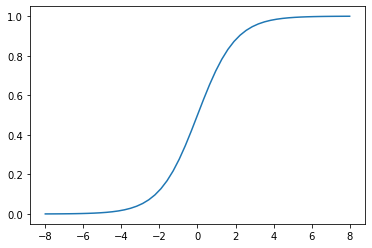

In [ ]:
plt.plot(z, sigmoid(z))

In [ ]:
def logistic_regression(xi):
    
    score=w0
    for j in range(len(w)):
        score=score+ xi[j] * w[j]
        
    result=sigmoid(score)
    
    return result
    

## 3.10 Training Logistic Regression with Scikit_Learn

* Train a model with Scikit-Learn
* Apply it to the validation dataset
* Calculate the accuracy

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model=LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model.coef_[0].round(2)

array([ 0.47, -0.17, -0.41, -0.03, -0.08,  0.06, -0.09, -0.08, -0.03,
       -0.07, -0.34,  0.32, -0.09,  0.  , -0.26,  0.14,  0.01,  0.06,
       -0.09, -0.08,  0.27, -0.09, -0.28, -0.23,  0.12, -0.17,  0.06,
       -0.09, -0.03,  0.07, -0.06,  0.14, -0.25,  0.22, -0.12, -0.09,
        0.1 , -0.07, -0.09,  0.05,  0.21, -0.09, -0.23, -0.07,  0.  ])

In [ ]:
model.intercept_[0]

-0.10903322824505347

In [ ]:
model.predict(X_val) # Hard Predictions (without probability)

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
y_pred= model.predict_proba(X_val)[:, 1] # soft predictions (with probability)

# 1 because it produces a 2d matrxi with non-churning and churning customers hence we chose the latter

In [ ]:
churn_decision=(y_pred >=0.5)

In [ ]:
df_val[churn_decision].customerid.reset_index(drop=True)

0      8433-wxgna
1      3440-jpscl
2      2637-fkfsy
3      7228-omtpn
4      6711-fldfb
          ...    
306    5976-jcjrh
307    2034-cgrhz
308    5276-kqwhg
309    6521-yytyi
310    3049-solay
Name: customerid, Length: 311, dtype: object

In [ ]:
# checking accuracy
(y_val==churn_decision).mean()

0.8034066713981547

In [ ]:
# Lets check the accuracy
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
# Same as what has been done on 2 code cells above
df_pred= pd.DataFrame()

df_pred['probability']=y_pred

df_pred['prediction']=churn_decision.astype(int)

df_pred['actual']= y_val

df_pred

,probability,prediction,actual
0,0.008997,0,0
1,0.204530,0,0
2,0.212228,0,0
3,0.543030,1,1
4,0.213788,0,0
...,...,...,...
1404,0.313685,0,0
1405,0.039358,0,1
1406,0.136387,0,0
1407,0.799761,1,1


In [ ]:
df_pred['correct']= df_pred['prediction']== df_pred['actual']

In [ ]:
df_pred.correct.mean()

0.8034066713981547

## 3.11 Model Interpretation

* Look at the coefficients
* Train a smaller model with fewer features

In [ ]:
dv.get_feature_names()

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

In [ ]:
model.coef_[0].round(2)

array([ 0.47, -0.17, -0.41, -0.03, -0.08,  0.06, -0.09, -0.08, -0.03,
       -0.07, -0.34,  0.32, -0.09,  0.  , -0.26,  0.14,  0.01,  0.06,
       -0.09, -0.08,  0.27, -0.09, -0.28, -0.23,  0.12, -0.17,  0.06,
       -0.09, -0.03,  0.07, -0.06,  0.14, -0.25,  0.22, -0.12, -0.09,
        0.1 , -0.07, -0.09,  0.05,  0.21, -0.09, -0.23, -0.07,  0.  ])

In [ ]:
dict(zip(dv.get_feature_names(),model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

In [ ]:
# Lets try training a smaller model with few features

small=['contract', 'tenure', 'monthlycharges']

In [ ]:
df_train[small].iloc[:10].to_dict(orient='records')

[{'contract': 'two_year', 'tenure': 72, 'monthlycharges': 115.5},
 {'contract': 'month-to-month', 'tenure': 10, 'monthlycharges': 95.25},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 75.55},
 {'contract': 'month-to-month', 'tenure': 5, 'monthlycharges': 80.85},
 {'contract': 'two_year', 'tenure': 18, 'monthlycharges': 20.1},
 {'contract': 'month-to-month', 'tenure': 4, 'monthlycharges': 30.5},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 75.1},
 {'contract': 'month-to-month', 'tenure': 1, 'monthlycharges': 70.3},
 {'contract': 'two_year', 'tenure': 72, 'monthlycharges': 19.75},
 {'contract': 'month-to-month', 'tenure': 6, 'monthlycharges': 109.9}]

In [ ]:
dicts_train_small=df_train[small].to_dict(orient='records')
dicts_val_small=df_val[small].to_dict(orient='records')

In [ ]:
dv_small=DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [ ]:
X_train_small= dv_small.transform(dicts_train_small)

In [ ]:
model_small=LogisticRegression()

In [ ]:
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [ ]:
w0=model_small.intercept_[0] # bias term

In [ ]:
w=model_small.coef_[0].round(3)
w  # the weights

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [ ]:
dict(zip(dv_small.get_feature_names(),w.round(3)))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

In [ ]:
#Using the bias term, we evaluate the customer churn score without knowing anything about them..
# We use sigmoid

-2.47 + 0.97 +50* 0.027 + 5*(-0.036)

-0.3300000000000001

In [ ]:
# we use the magic variable _ and use it as a parameter in sigmoid(Only jupyter , not kaggle)

sigmoid(-0.3300000000000001)

0.41824062315816374

In [ ]:
# suppose they pay 60 dollars and have stayed for 1 month
-2.47 + 0.97 +60* 0.027 + 1*(-0.036)

0.08399999999999966

In [ ]:
# positive z SCORE means
sigmoid(0.08399999999999966)

0.5209876607065322

In [ ]:
# Assuming 2 year contract, tenure 24 months and  they pay 30 dollas/m
-2.47 + (-0.949) +30* 0.027 + 24*(-0.036)

-3.473

In [ ]:
sigmoid(-3.473)

0.030090303318277657

## 3.12 Using the Model

In [ ]:
# Train the model using the whole data and all the features noe

dicts_full_train=df_full_train[categorical + numerical].to_dict(orient='records')

In [ ]:
dicts_full_train[:2]

[{'gender': 'male',
  'seniorcitizen': 0,
  'partner': 'yes',
  'dependents': 'yes',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'no',
  'onlinesecurity': 'no_internet_service',
  'onlinebackup': 'no_internet_service',
  'deviceprotection': 'no_internet_service',
  'techsupport': 'no_internet_service',
  'streamingtv': 'no_internet_service',
  'streamingmovies': 'no_internet_service',
  'contract': 'two_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'mailed_check',
  'tenure': 12,
  'monthlycharges': 19.7,
  'totalcharges': 258.35},
 {'gender': 'female',
  'seniorcitizen': 0,
  'partner': 'no',
  'dependents': 'no',
  'phoneservice': 'yes',
  'multiplelines': 'no',
  'internetservice': 'dsl',
  'onlinesecurity': 'yes',
  'onlinebackup': 'yes',
  'deviceprotection': 'yes',
  'techsupport': 'yes',
  'streamingtv': 'no',
  'streamingmovies': 'yes',
  'contract': 'one_year',
  'paperlessbilling': 'no',
  'paymentmethod': 'credit_card_(automatic)',
  'tenur

In [ ]:
dv= DictVectorizer(sparse=False)

In [ ]:
dv.fit(dicts_full_train)

DictVectorizer(sparse=False)

In [ ]:
X_full_train=dv.transform(dicts_full_train)

In [ ]:
model=LogisticRegression()
model.fit(X_full_train, y_full_train)

LogisticRegression()

In [ ]:
# now for the test data set
dicts_test=df_test[categorical + numerical].to_dict(orient='records')

In [ ]:
X_test=dv.transform(dicts_test)

In [ ]:
y_pred=model.predict_proba(X_test)[:,1]

In [ ]:
churn_decision=(y_pred >=0.5)

In [ ]:
(churn_decision== y_test).mean()

0.815471965933286

In [ ]:
#  picking a random customer from the test set
customer=dicts_test[-1]

customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [ ]:
# we want to convert the customer data into a feature matrix(directly because the Dict Vectorizer already can convert the data into a numpy ndarray)
X_small=dv.transform([customer])

In [ ]:
X_small.shape

(1, 45)

In [ ]:
# predicting the likelihood of churning
model.predict_proba(X_small)[0,1]

0.5968852088244745

In [ ]:
# checking whether he was going to churn

y_test[-1]

1

# Section 4

## 4.2 Accuracy and Dummy Model
* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines.

In [13]:
# using the validation dataset

len(y_val)

NameError: name 'y_val' is not defined

In [ ]:
# correct decisions made by the model
(y_val==churn_decision).sum()

In [ ]:
#KLets try other thresholds to see if our accuracy improves
thresholds=np.linspace(0,1,21)
thresholds

In [ ]:
scores=[]
for t in  thresholds:
    churn_decision=(y_pred>=t)
    score=(y_val==churn_decision).mean()
    
    print("%.2f %.3f" % (t,score))
    scores.append(score)

In [ ]:
# Plotting them

plt.plot(thresholds, scores)
plt.grid(True)

The peak and scores show that indeed 0.5 is the best choice becuase it has the highest threshold.

#### We can however use the sckit learn library to evaluate the accuracies.


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred>=0.5, normalize=True)

In [ ]:
scores=[]
for t in  thresholds:
    score=accuracy_score(y_val, y_pred>=t)
    
    
    
    print("%.2f %.3f" % (t,score))
    scores.append(score)

In [ ]:
y_pred>=1.0

from collections import Counter

Counter(y_pred>=1.0)

In [ ]:
Counter(y_val)

### 4.3 Confusion Table
* Different types of erros and correct decsions
* Arranging them in table

In [ ]:
actual_positive=(y_val==1)
actual_negative=(y_val==0)

actual_positive

In [ ]:
t=0.5
predict_positive=(y_pred>=t)
predict_negative=(y_pred<t)

In [ ]:
# We use binary operations in numpy(returns and array ONLY if both are true)
tp=(predict_positive & actual_positive).sum()
tn=(predict_negative & actual_negative).sum()
fp=(predict_positive & actual_negative).sum()
fn=(predict_negative & actual_positive).sum()

In [ ]:
predict_positive[2:10]

In [ ]:
actual_positive[2:10]

In [ ]:
# numpy confusion matrix
confusion_matrix=np.array([[tn,fp],[fn, tp]])
confusion_matrix

In [ ]:
# normalizing
confusion_matrix/confusion_matrix.sum() *100

## 4.4 Precision and Recall

In [ ]:
precision=tp/(fp+tp)

precision

In [ ]:
recall=tp/(tp+fn)
recall

## 4.5 ROC CURVES
Stands for receiver operating characteristics. pr 
### TPR and FPR

In [ ]:
tpr=tp/(tp+fn)

fpr=fp/(fp+tn)

tpr, fpr

In [ ]:
scores=[]
thresholds=np.linspace(0,1,101)

for t in thresholds:
    actual_positive=(y_val==1)
    actual_negative=(y_val==0)
    
    predict_positive=(y_pred>=t)
    predict_negative=(y_pred<t)
    
    tp=(predict_positive & actual_positive).sum()
    tn=(predict_negative & actual_negative).sum()
    fp=(predict_positive & actual_negative).sum()
    fn=(predict_negative & actual_positive).sum()
    
    scores.append((t,tp, fp, fn, tn))
    
scores

In [ ]:
#turning it into a pandas dataframe..list of tuples
columns=["thresholds",'tp', 'fp','fn','tn']
df_scores=pd.DataFrame(scores, columns=columns)
df_scores['tpr']=df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores['fpr']=df_scores.fp/(df_scores.fp+df_scores.tn)


In [ ]:
df_scores['tpr']=df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores['fpr']=df_scores.fp/(df_scores.fp+df_scores.tn)

df_scores[::10]

In [ ]:
# Now we can plot them
plt.plot(df_scores.thresholds,df_scores['tpr'], label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'], label='FPR')
plt.grid(True)
plt.legend(loc=3)

Dummy model with threshold 0 that 'predicts everyone is churning" has the highest FPR and TPR at one.
We want to ensure that FPR goes down, down as quickly as possible.
We also want to ensure that TPR sticks around 1.


## Random Model
Making decisions about the model randomly. To identify the base line.

In [ ]:
np.random.seed(1)
y_rand=np.random.uniform(0,1, size=len(y_val))
y_rand.round(3)

For each customer randomly predict if they are going to churn or not.And compare it to the `y_val`

In [ ]:
(y_val==(y_rand>=0.5)).mean()

In [ ]:
# Create a fucntion fot tpr and fpr to passs any predictins
def tpr_fpr_dataframe(y_val, y_pred):
    scores=[]
    thresholds=np.linspace(0,1,101)

    for t in thresholds:
        actual_positive=(y_val==1)
        actual_negative=(y_val==0)

        predict_positive=(y_pred>=t)
        predict_negative=(y_pred<t)

        tp=(predict_positive & actual_positive).sum()
        tn=(predict_negative & actual_negative).sum()
        fp=(predict_positive & actual_negative).sum()
        fn=(predict_negative & actual_positive).sum()

        scores.append((t,tp, fp, fn, tn))
    columns=["thresholds",'tp', 'fp','fn','tn']
    df_scores=pd.DataFrame(scores, columns=columns)
    df_scores['tpr']=df_scores.tp/(df_scores.tp+df_scores.fn)
    df_scores['fpr']=df_scores.fp/(df_scores.fp+df_scores.tn)
    
    return df_scores

In [ ]:
# For the random predictions
df_rand=tpr_fpr_dataframe(y_val, y_rand)

df_rand[::10]

In [ ]:
plt.plot(df_rand.thresholds,df_rand['tpr'], label='TPR')
plt.plot(df_rand.thresholds,df_rand['fpr'], label='FPR')
plt.grid(True)
plt.legend(loc=3)

## IDEAL MODEL


In [ ]:
num_neg=(y_val==0).sum()
num_pos=(y_val==1).sum()

num_neg, num_pos

In [ ]:
y_ideal=np.repeat([0,1],[num_neg, num_pos])
y_ideal

In [ ]:
# creating predictions that a just numbrs between 0 and 1
y_ideal_pred=np.linspace(0,1, len(y_val))

In [ ]:
((y_ideal_pred>=0.726)==y_ideal).mean()

In [ ]:
df_ideal=tpr_fpr_dataframe(y_ideal, y_ideal_pred)

df_ideal[::10]

In [ ]:
plt.plot(df_ideal.thresholds,df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.thresholds,df_ideal['fpr'], label='FPR')
plt.grid(True)
plt.legend(loc=3)

### Putting Everything Together

#### Actual,Random, Ideal

In [ ]:
plt.plot(df_scores.thresholds,df_scores['tpr'], label='TPR')
plt.plot(df_scores.thresholds,df_scores['fpr'], label='FPR')

plt.plot(df_ideal.thresholds,df_ideal['tpr'], label='TPR', color='black')
plt.plot(df_ideal.thresholds,df_ideal['fpr'], label='FPR',color='black')



# plt.plot(df_rand.thresholds,df_rand['tpr'], label='TPR')
# plt.plot(df_rand.thresholds,df_rand['fpr'], label='FPR')



plt.legend(loc=3)
plt.grid(True)


In [ ]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr,df_scores.tpr, label='model' )
# plt.plot(df_rand.fpr,df_rand.tpr , label='random')
#plt.plot(df_ideal.fpr,df_ideal.tpr, label= 'ideal' )
plt.plot([0,1],[0,1], label='random')


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.grid(True)

In [ ]:
# Using sklearn to do ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_val, y_pred)

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(fpr, tpr, label='model' )
# plt.plot(df_rand.fpr,df_rand.tpr , label='random')
#plt.plot(df_ideal.fpr,df_ideal.tpr, label= 'ideal' )
plt.plot([0,1],[0,1], label='random')


plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.grid(True)

### ROC AUC
* Area under the ROC curve- useful metric
* Interpreation of AUC

In [ ]:
from sklearn.metrics import auc
auc(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

In [ ]:
#it means what is the y_pred score when y_val(actual) is 0 and v.v for 1 is also similar.
neg=y_pred[y_val==0]
pos=y_pred[y_val==1]
pos

In [ ]:
#Lets have 1000000 iterations
import random
n=1000000

success=0

for i in range(n):

    pos_idx=random.randint(0, len(pos)-1)
    neg_idx=random.randint(0, len(neg)-1)

    if pos[pos_idx]>neg[neg_idx]:
        success=success+1
        
success/n

In [ ]:
#we can use numpy for the above
n=50000
np.random.seed(1)
pos_idx=np.random.randint(0, len(pos), size=n)
neg_idx=np.random.randint(0, len(neg), size=n)
(pos[pos_idx]>  neg[neg_idx]).mean()

In [ ]:
#selecting the scores of these customers
pos_idx>  neg_idx

### Cross- Validation (Parameter Tuning)
* Evaluating the same model on different subsets of Data.
* Getting the average prediction and the spread within predictions

In [ ]:
def train(df_train,y_train, C=1.0):
    dicts=df_train[categorical+numerical].to_dict(orient='records')
                                   
    dv=DictVectorizer(sparse=False)
    
    
    X_train=dv.fit_transform(dicts)
    
    model=LogisticRegression(solver='liblinear', max_iter=10000 )
    model.fit(X_train,y_train)
    
    return dv, model

In [ ]:
dv, model=train(df_train,y_train, C=0.0001)

In [ ]:
# call another function that makes predictions
def predict(df,dv,model):
    dicts=df[categorical+numerical].to_dict(orient='records')
    X=dv.transform(dicts)
    y_pred=model.predict_proba(X)[:,1]
    
    return y_pred

In [ ]:
y_pred=predict(df_val,dv, model)

In [ ]:
# Now calling K-fold cross validation from sklearn
from sklearn.model_selection import KFold
kf=KFold(n_splits=10, shuffle=True, random_state=1) 

In [ ]:
kf.split(df_full_train)

train_idx, val_idx=next(kf.split(df_full_train))

len(train_idx), len(val_idx)

In [ ]:
df_train=df_full_train.iloc[train_idx]
df_val=df_full_train.iloc[val_idx]

In [ ]:
from tqdm import tqdm 
import time

In [ ]:
for C in tqdm([0.0001,0.001,0.01,0.5,1,5,10]):
    scores=[]

    for train_idx, val_idx in kf.split(df_full_train):
    
        df_train=df_full_train.iloc[train_idx]
        df_val=df_full_train.iloc[val_idx]

        y_train=df_train.churn.values
        y_val=df_val.churn.values

        dv, model=train(df_train,y_train, C=C)
        y_pred=predict(df_val,dv, model)

        auc=roc_auc_score(y_val, y_pred)

        scores.append(auc)
        
    print("C=%s %.3f %.3f" %(C, np.mean(scores), np.std(scores)))
    

In [ ]:
dv, model=train(df_full_train,df_full_train.churn.values, C=0.00001)
y_pred=predict(df_test,dv, model)
auc=roc_auc_score(y_test, y_pred)

auc